**벡터 정규화**  
벡터 정규화란 한 벡터를 벡터의 길이로 나누어서 그 벡터의 길이를 1로 만드는 것입니다. 이렇게 길이가 1이 된 벡터를 단위 벡터라고 부릅니다. 주로 키보드로 조작하는 게임에 자주 사용하는 정규화 방식으로 (1,0) 벡터와 (0,1) 벡터가 합쳐졌을 때 (1,1) 벡터의 길이가 루트2로 1보다 더 크기 때문에 이를 정규화를 통해 이 길이를 1로 맞춰주어야 하기 때문입니다. 속력과 방향을 정의되는 벡터에서 순수하게 방향만을 남겨서 사용하고자 할 때 위와 같은 벡터 정규화 개념을 사용합니다.

벡터 정규화를 하는 방법은 각 성분(x, y, z)에 벡터의 길이를 나누는 것입니다.

In [1]:
import numpy as np

data_yes = np.load('vector_normalization/train/seq_yes.npy')
data_no = np.load('vector_normalization/train/seq_no.npy')
data_like = np.load('vector_normalization/train/seq_like.npy')
data_heart = np.load('vector_normalization/train/seq_heart.npy')

print(data_yes.shape)
print(data_no.shape)
print(data_like.shape)
print(data_heart.shape)

(711, 10, 111)
(718, 10, 111)
(1072, 10, 111)
(1139, 10, 111)


In [2]:
test_yes = np.load('vector_normalization/new_test/seq_yes.npy')
test_no = np.load('vector_normalization/new_test/seq_no.npy')
test_like = np.load('vector_normalization/new_test/seq_like.npy')
test_heart = np.load('vector_normalization/new_test/seq_heart.npy')

In [3]:
actions = ['yes', 'no', 'like', 'heart']

data = np.concatenate([data_yes ,data_no, data_like, data_heart], axis=0)
data_te = np.concatenate([test_yes ,test_no, test_like, test_heart], axis=0)

data.shape, data_te.shape

((3640, 10, 111), (3933, 10, 111))

#### 데이터 x, y 나누기

In [4]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

x_data_te = data_te[:, :, :-1]
labels_te = data_te[:, 0, -1]

print(x_data.shape)
print(labels.shape)
print()
print(x_data_te.shape)
print(labels_te.shape)

(3640, 10, 110)
(3640,)

(3933, 10, 110)
(3933,)


In [5]:
np.unique(labels), np.unique(labels_te)

(array([0., 1., 2., 3.]), array([0., 1., 2., 3.]))

In [6]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data_te = to_categorical(labels_te, num_classes=len(actions))

y_data.shape, y_data_te.shape

((3640, 4), (3933, 4))

#### X,y train_test_split

In [7]:
from sklearn.model_selection import train_test_split
np.random.seed(1)

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_data_te = x_data_te.astype(np.float32)
y_data_te = y_data_te.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.25, random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_data_te.shape, y_data_te.shape)

(2730, 10, 110) (2730, 4)
(910, 10, 110) (910, 4)
(3933, 10, 110) (3933, 4)


#### 판단 척도

판단 척도는 **F1 score**를 사용하였습니다. **F1 score**는 정밀도와 재현율을 결합한 지표로 정밀도와 재현율이 어느 한 쪽으로 치우치지 않을 때 높은 값을 나타냅니다.

In [8]:
import tensorflow as tf
def metric_F1score(y_true,y_pred): 
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    precision=TP/(TP+FP)
    recall=TP/(TP+FN)
    F1score=2*precision*recall/(precision+recall)
    return F1score

####  Modeling

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[metric_F1score])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                44800     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 47,012
Trainable params: 47,012
Non-trainable params: 0
_________________________________________________________________


#### Training

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    callbacks=[
        ModelCheckpoint('models/vector_normalization_classifier.h5', monitor='val_metric_F1score', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_metric_F1score', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/50
85/86 [============================>.] - ETA: 0s - loss: 10.4170 - metric_F1score: 0.5072
Epoch 00001: val_metric_F1score improved from inf to 0.84709, saving model to models\vector_normalization_classifier.h5
86/86 [==============================] - 7s 26ms/step - loss: 10.3887 - metric_F1score: 0.5111 - val_loss: 0.7562 - val_metric_F1score: 0.8471 - lr: 0.0010
Epoch 2/50
85/86 [============================>.] - ETA: 0s - loss: 1.6364 - metric_F1score: 0.7818
Epoch 00002: val_metric_F1score did not improve from 0.84709
86/86 [==============================] - 2s 23ms/step - loss: 1.6329 - metric_F1score: 0.7820 - val_loss: 0.1721 - val_metric_F1score: 0.9545 - lr: 0.0010
Epoch 3/50
85/86 [============================>.] - ETA: 0s - loss: 0.6754 - metric_F1score: 0.8877
Epoch 00003: val_metric_F1score did not improve from 0.84709
86/86 [==============================] - 2s 23ms/step - loss: 0.6729 - metric_F1score: 0.8890 - val_loss: 0.1012 - val_metric_F1score: 0.9816 - lr

Epoch 27/50
86/86 [==============================] - ETA: 0s - loss: 0.0361 - metric_F1score: 0.9944
Epoch 00027: val_metric_F1score did not improve from 0.84709
86/86 [==============================] - 2s 23ms/step - loss: 0.0361 - metric_F1score: 0.9944 - val_loss: 0.0200 - val_metric_F1score: 0.9989 - lr: 0.0010
Epoch 28/50
85/86 [============================>.] - ETA: 0s - loss: 0.1193 - metric_F1score: 0.9899
Epoch 00028: val_metric_F1score did not improve from 0.84709
86/86 [==============================] - 2s 23ms/step - loss: 0.1188 - metric_F1score: 0.9900 - val_loss: 0.0063 - val_metric_F1score: 0.9978 - lr: 0.0010
Epoch 29/50
84/86 [============================>.] - ETA: 0s - loss: 0.0231 - metric_F1score: 0.9952
Epoch 00029: val_metric_F1score did not improve from 0.84709
86/86 [==============================] - 2s 23ms/step - loss: 0.0228 - metric_F1score: 0.9953 - val_loss: 0.0011 - val_metric_F1score: 0.9989 - lr: 0.0010
Epoch 30/50
85/86 [============================>.

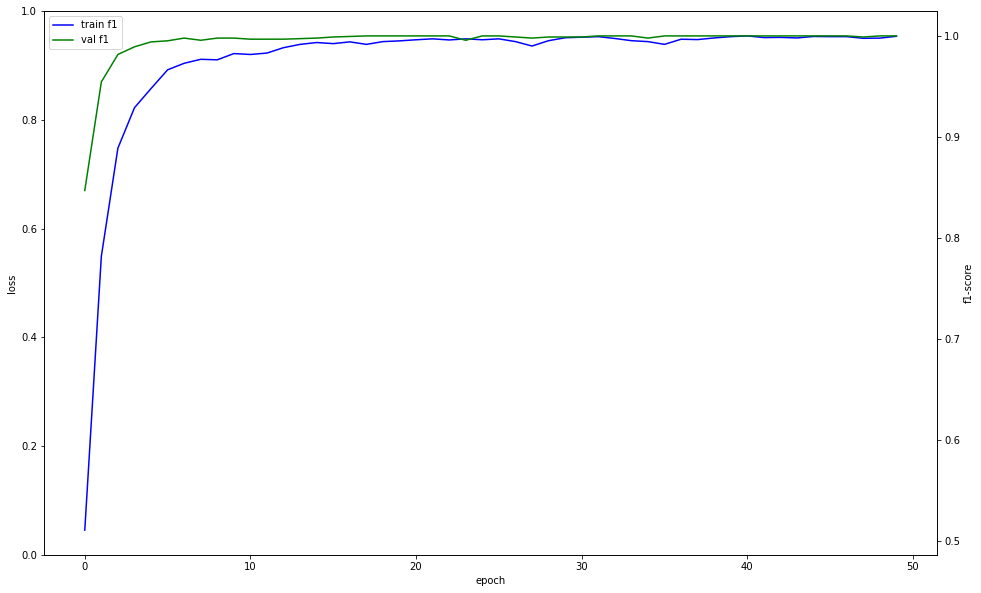

In [11]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

acc_ax.plot(history.history['metric_F1score'], 'b', label='train f1')
acc_ax.plot(history.history['val_metric_F1score'], 'g', label='val f1')
acc_ax.set_ylabel('f1-score')
acc_ax.legend(loc='upper left')

plt.show()

####  Results Analysis

In [12]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/vector_normalization_classifier.h5', custom_objects = {'metric_F1score':metric_F1score})

In [13]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

y_pred = model.predict(x_val)
multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[703,  14],
        [ 46, 147]],

       [[705,  17],
        [ 51, 137]],

       [[592,  60],
        [ 20, 238]],

       [[588,  51],
        [ 25, 246]]], dtype=int64)

In [14]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.91      0.76      0.83       193
           1       0.89      0.73      0.80       188
           2       0.80      0.92      0.86       258
           3       0.83      0.91      0.87       271

    accuracy                           0.84       910
   macro avg       0.86      0.83      0.84       910
weighted avg       0.85      0.84      0.84       910



---

test data로 모델 예측

In [15]:
pred = model.predict(x_data_te);pred

array([[9.6678413e-02, 8.4249437e-02, 1.6021604e-02, 8.0305058e-01],
       [4.1810136e-02, 3.1565867e-02, 5.9916116e-03, 9.2063236e-01],
       [2.6559686e-02, 4.9321852e-03, 7.3336856e-04, 9.6777481e-01],
       ...,
       [2.2740485e-11, 3.2241365e-12, 9.9703252e-01, 2.9675148e-03],
       [2.3038800e-10, 1.5812891e-10, 9.8987329e-01, 1.0126760e-02],
       [1.4360139e-09, 2.6245001e-10, 9.8822355e-01, 1.1776412e-02]],
      dtype=float32)

In [16]:
y_data_te

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [17]:
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(np.argmax(y_data_te, axis=1), np.argmax(pred, axis=1))

array([[[2869,   43],
        [ 417,  604]],

       [[3153,   87],
        [ 106,  587]],

       [[2472,  368],
        [ 146,  947]],

       [[2443,  364],
        [ 193,  933]]], dtype=int64)

In [18]:
print(classification_report(np.argmax(y_data_te, axis=1), np.argmax(pred, axis=1)))

              precision    recall  f1-score   support

           0       0.93      0.59      0.72      1021
           1       0.87      0.85      0.86       693
           2       0.72      0.87      0.79      1093
           3       0.72      0.83      0.77      1126

    accuracy                           0.78      3933
   macro avg       0.81      0.78      0.78      3933
weighted avg       0.80      0.78      0.78      3933



In [19]:
metric_F1score(y_data_te, pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7763983>

In [44]:
import tensorflow as tf
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('models/vector_normalization_classifier.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\hites\AppData\Local\Temp\tmphc55gmre\assets


INFO:tensorflow:Assets written to: C:\Users\hites\AppData\Local\Temp\tmphc55gmre\assets


ConverterError: C:\Users\hites\anaconda3\lib\site-packages\tensorflow\python\saved_model\save.py:1315:0: error: 'tf.TensorListReserve' op requires element_shape to be static during TF Lite transformation pass
<unknown>:0: note: loc("StatefulPartitionedCall"): called from
C:\Users\hites\anaconda3\lib\site-packages\tensorflow\python\saved_model\save.py:1315:0: error: failed to legalize operation 'tf.TensorListReserve' that was explicitly marked illegal
<unknown>:0: note: loc("StatefulPartitionedCall"): called from
<unknown>:0: error: Lowering tensor list ops is failed. Please consider using Select TF ops and disabling `_experimental_lower_tensor_list_ops` flag in the TFLite converter object. For example, converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]\n converter._experimental_lower_tensor_list_ops = False
